

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
!pip install -U torch torchvision

In [ ]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58284000 @  0x7fdd11aa72a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
torch.cuda.empty_cache()
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [5]:
!ls train

simpsons_dataset


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Nov 29 19:23:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    26W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.utils.data.sampler import Sampler

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [8]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)


train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

# словарь в котором ключи - персонажи Симпсонов, а значения - списки с путями к картинкам.
dct_path_train = create_dct_path_labels(train_files, train_labels)

for person in dct_path_train: # дополняем классы картинок, в которых содержится менее 100 картинок до сотни, чтобы они распознавались лучше
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")



abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [13]:
new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])


new_train_label = [path.parent.name for path in new_train_files] # классы train
new_train_dataset = SimpsonsDataset(new_train_files, mode='train') 
val_dataset = SimpsonsDataset(val_files, mode='val')

#dct_path_train = create_dct_path_labels(new_train_files, new_train_label)
#dct_simpsons_wht = {}
#for person in dct_path_train:
    #dct_simpsons_wht.update({person: 1. / len(dct_path_train[person])})

#def make_weights_for_balanced_classes(train_label, dct):
  #class_weights = torch.tensor([dct[i] for i in train_label])
  #return class_weights


#samples_train_weight = make_weights_for_balanced_classes(train_labels, dct_simpsons_wht) # пытался реализовать метод Random Weighted Sampler, но, видимо, что-то написал неправильно - синтаксических ошибок нет, но точность при обучении резко упала
#print(samples_train_weight)
#sampler_train_wht = torch.utils.data.WeightedRandomSampler(samples_train_weight, len(samples_train_weight))

BATCH_SIZE = 64
# объявляем DataLoaders, которые будут "вытаскивать" данные батчами с вышеуказанной размерностью
Dataloaders = {'train': DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle = True),
               'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)}
dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

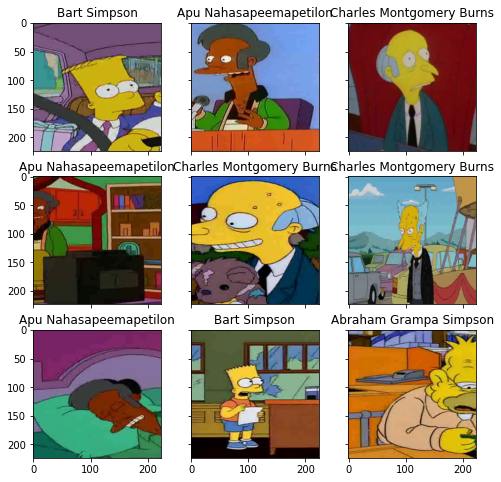

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [15]:
# Очень простая сеть, в архитектуру которой добавлены BatchNorms и Dropout с гиперпараметром, равным 0.3 (размещаем после BatchNorm, ибо могут быть проблемы со статистиками, которые batchnorm считает для применения во время предсказаний)
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn1 = nn.BatchNorm2d(8)
        self.dropout1 = nn.Dropout(p=0.4)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn2 = nn.BatchNorm2d(16)
        #self.dropout2 = nn.Dropout(p=0.3)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        #x = self.dropout2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [18]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 3, 0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [19]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [31]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (

Запустим обучение сети.

In [20]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

new_train_dataset = SimpsonsDataset(new_train_files, mode='train') 


In [ ]:
history = train(new_train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 1.9077863462227411


epoch:  20%|██        | 1/5 [03:12<12:49, 192.45s/it]


Epoch 001 train_loss: 1.9078     val_loss 1.5680 train_acc 0.4897 val_acc 0.5566
loss 0.9600417505181305


epoch:  40%|████      | 2/5 [06:24<09:36, 192.29s/it]


Epoch 002 train_loss: 0.9600     val_loss 0.9889 train_acc 0.7364 val_acc 0.7348
loss 0.5692854474443908


epoch:  60%|██████    | 3/5 [09:36<06:24, 192.26s/it]


Epoch 003 train_loss: 0.5693     val_loss 0.7978 train_acc 0.8397 val_acc 0.7881
loss 0.2626470677966936


epoch:  80%|████████  | 4/5 [12:49<03:12, 192.39s/it]


Epoch 004 train_loss: 0.2626     val_loss 0.7504 train_acc 0.9268 val_acc 0.8122
loss 0.1595956229844295


epoch: 100%|██████████| 5/5 [16:02<00:00, 192.50s/it]


Epoch 005 train_loss: 0.1596     val_loss 0.7917 train_acc 0.9549 val_acc 0.8074


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

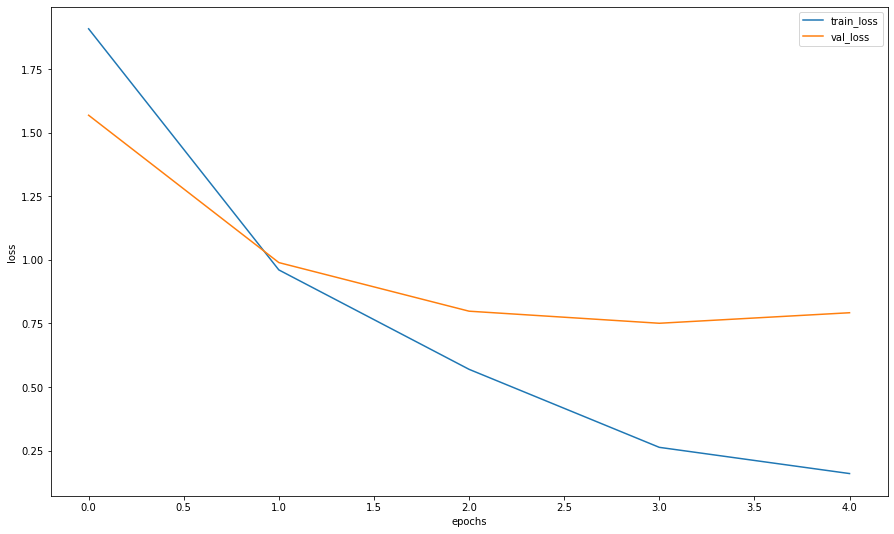

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [21]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

NameError: ignored

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


0.75

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

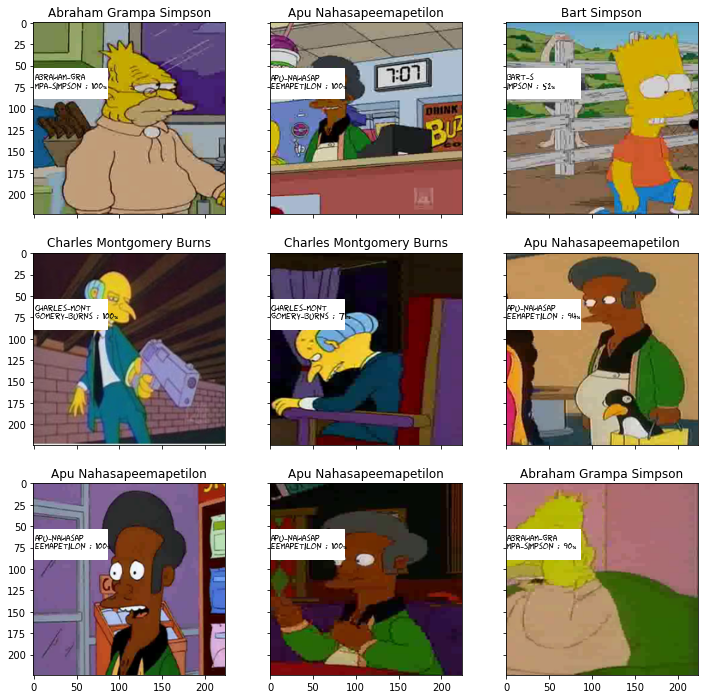

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [23]:
from torchvision import models

In [24]:
model_resnet = models.resnet50(pretrained=True).to(DEVICE) # применим Fine Tuning для reshnet50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [25]:
model_resnet # взглянем на архитектуру сети

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for i, child in enumerate(model_resnet.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = False

model_resnet.fc = nn.Sequential(nn.Linear(2048,n_classes))

In [33]:
model_resnet = model_resnet.cuda()

In [34]:
history = train(new_train_dataset, val_dataset, model=model_resnet, epochs=3, batch_size=64)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 2.9853521923088895


epoch:  33%|███▎      | 1/3 [04:47<09:35, 287.75s/it]


Epoch 001 train_loss: 2.9854     val_loss 2.5446 train_acc 0.2516 val_acc 0.3928
loss 2.394105483639625


epoch:  67%|██████▋   | 2/3 [09:33<04:46, 286.45s/it]


Epoch 002 train_loss: 2.3941     val_loss 2.1101 train_acc 0.4998 val_acc 0.5898
loss 2.004194426042648


epoch: 100%|██████████| 3/3 [14:19<00:00, 286.38s/it]


Epoch 003 train_loss: 2.0042     val_loss 1.8344 train_acc 0.5828 val_acc 0.6221


In [37]:
import copy

# сохранить веса нашей нейросети model
model_pre_weights = copy.deepcopy(model_resnet.state_dict())
torch.save(model_pre_weights, "path_to\\model_pre_weights.pth")

In [38]:
# Включаем все слои!!!
for child in model_resnet.children():
    for param in child.parameters():
        param.requires_grad = True

In [39]:
history = train(new_train_dataset, val_dataset, model=model_resnet, epochs=3, batch_size=64)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 0.5652411181322038


epoch:  33%|███▎      | 1/3 [08:29<16:58, 509.28s/it]


Epoch 001 train_loss: 0.5652     val_loss 0.2743 train_acc 0.8601 val_acc 0.9295
loss 0.13863933592082198


epoch:  67%|██████▋   | 2/3 [16:58<08:28, 508.99s/it]


Epoch 002 train_loss: 0.1386     val_loss 0.2296 train_acc 0.9645 val_acc 0.9410
loss 0.08145354504256859


epoch: 100%|██████████| 3/3 [25:27<00:00, 509.22s/it]


Epoch 003 train_loss: 0.0815     val_loss 0.1755 train_acc 0.9779 val_acc 0.9561


In [40]:
loss, acc, val_loss, val_acc = zip(*history)

In [41]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_resnet, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_resnet, imgs)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

0.9500000000000001

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [51]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [58]:
! ls 

 characters_illustration.png	  resnet18_25epoch.csv	    submission.csv
 gdrive				  sample_data		    testset
 label_encoder.pkl		  sample_submission.csv     train
'path_to\model_pre_weights.pth'   simple_cnn_baseline.csv


In [57]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('./submission.csv', index=False)

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [54]:
#my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
